# Import des modules

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,MultiLabelBinarizer

bc = pd.read_csv('seatle_after_analyze.csv')

# Discrétisation de la valeur Année

- Création de la colonne "YearBuiltDecade" afin de regrouper les données par décade

In [29]:
# Creation d'une nouvelle colonne suivant la valeur de YearBuilt
bc['YearBuiltDecade'] = pd.cut(bc['YearBuilt'], bins=range(1900, 2030, 10), right=False)
bc['YearBuiltDecade'] = bc['YearBuiltDecade'].astype(str)
bc['YearBuiltDecade'] = bc['YearBuiltDecade'].str.replace('[', '').str.split(',').str[0].astype(float)

# Encodage des données en binaire

- Un batiment consomme de l'électricité ET du gaz : Colonne "HasGas" = 1
- Un batiment possède un parking : Colonne "HasParking" = 1

In [30]:
# Creation d'une nouvelle colonne suivant la valeur de PropertyGFAParking
bc['HasParking'] = bc['PropertyGFAParking'].apply(lambda x: 1 if x > 0 else 0)

# Creation d'une nouvelle colonne suivant la valeur de NaturalGas(kBtu)
bc['HasGas'] = bc['NaturalGas(kBtu)'].apply(lambda x: 1 if x > 0 else 0)

# Encodage des types de batiments

- PrimaryPropertyType
- Méthode pour numériser des catégories non ordonnées >>> one hot encoding

In [31]:
encoder = OneHotEncoder(sparse_output=False)  # Return dense array
encoded = encoder.fit_transform(bc[['PrimaryPropertyType']])  # Note double brackets

# Create DataFrame with proper column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['PrimaryPropertyType']))

# Remplacer le préfixe par défaut par 'ppt_'
encoded_df.columns = [col.replace('PrimaryPropertyType_', 'ppt_') for col in encoded_df.columns]

bc = pd.concat([bc, encoded_df], axis=1)

# Encodage de la localisation des batiments

- Neighborhood
- Méthode pour numériser des catégories non ordonnées >>> one hot encoding

In [32]:
encoder = OneHotEncoder(sparse_output=False)  # Return dense array
encoded = encoder.fit_transform(bc[['Neighborhood']])  # Note double brackets

# Create DataFrame with proper column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Neighborhood']))

# Remplacer le préfixe par défaut par 'ppt_'
encoded_df.columns = [col.replace('Neighborhood_', 'nbh_') for col in encoded_df.columns]

bc = pd.concat([bc, encoded_df], axis=1)

# Encodage des usages des batiments

- ListOfAllPropertyUseTypes

Nombre de valeurs regroupées en RARE : 33

Résultat MultiLabelBinarizer :

Colonnes créées: ['Bank Branch', 'College/University', 'Data Center', 'Distribution Center', 'Fitness Center/Health Club/Gym', 'Food Service', 'Hotel', 'K-12 School', 'Manufacturing/Industrial Plant', 'Medical Office', 'Multifamily Housing', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Entertainment/Public Assembly', 'Other - Recreation', 'Other - Services', 'Parking', 'Pre-school/Daycare', 'Rare', 'Refrigerated Warehouse', 'Residence Hall/Dormitory', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Senior Care Community', 'Social/Meeting Hall', 'Supermarket/Grocery Store', 'Worship Facility']
ListOfAllPropertyUseTypes_Count
1    690
2    407
3    149
4     56
5     25
6      8
7      2
Name: count, dtype: int64


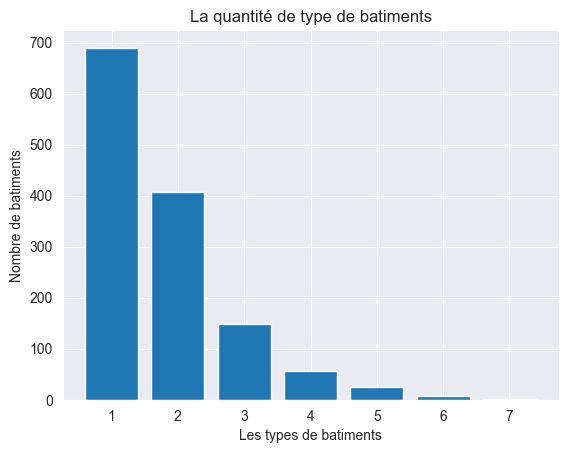

In [33]:
# Supprimer tout ce qui est entre parenthèses (y compris les parenthèses elles-mêmes)
bc["ListOfAllPropertyUseTypes"] = bc["ListOfAllPropertyUseTypes"].str.replace(r"\([^)]*\)", "", regex=True)

all_values = []
for row in bc['ListOfAllPropertyUseTypes']:
    values = [v.strip() for v in str(row).split(',')]
    all_values.extend(values)

# Compter et trier par fréquence (décroissant)

value_counts = Counter(all_values)
sorted_values = value_counts.most_common()

#print("Valeurs triées par fréquence :")
#for value, count in sorted_values:
#    print(f"{value}: {count}")

    # Identifier les valeurs avec moins de 10 occurrences
rare_values = [value for value, count in value_counts.items() if count < 10]

# Créer une nouvelle colonne avec regroupement "Divers"
def categorize_property_types(row):
    if pd.isna(row):
        return row
    values = [v.strip() for v in str(row).split(',')]
    new_values = []
    for value in values:
        if value in rare_values:
            new_values.append('Rare')
        else:
            new_values.append(value)
    return ', '.join(new_values)

bc['ListOfAllPropertyUseTypes_Grouped'] = bc['ListOfAllPropertyUseTypes'].apply(categorize_property_types)

# Afficher les statistiques
print(f"Nombre de valeurs regroupées en RARE : {len(rare_values)}")

######################################################

property_use_lists = []
for row in bc['ListOfAllPropertyUseTypes_Grouped']:
    values = [v.strip() for v in str(row).split(',')]
    property_use_lists.append(values)

mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(property_use_lists)
# Ajouter le préfixe "p_"
col_names = ["p_" + c for c in mlb.classes_]

mlb_df = pd.DataFrame(mlb_result, columns=col_names, index=bc.index)

bc = pd.concat([bc, mlb_df], axis=1)

print(f"\nRésultat MultiLabelBinarizer :")
print(f"\nColonnes créées: {list(mlb.classes_)}")

######################################################

# Compter le nombre de 1 par ligne dans les colonnes "p_..."
bc["ListOfAllPropertyUseTypes_Count"] = bc[bc.columns[bc.columns.str.startswith("p_")]].sum(axis=1)

# Vérifier si supérieur à 1
#bc["properties"] = bc["count_ones"] > 1

# Remplacer True/False par du texte plus parlant
#bc["properties_label"] = bc["properties"].map({
#    True: "Plusieurs types de batiments",
#    False: "Un seul type de batiment"
#})

counts = bc["ListOfAllPropertyUseTypes_Count"].value_counts()
print(counts)

# Création du graphique
plt.bar(counts.index.astype(str), counts.values)

plt.xlabel("Les types de batiments")
plt.ylabel("Nombre de batiments")
plt.title("La quantité de type de batiments")
plt.show()

# Création de nouvelles features

- La surface totale des batiments divisé par le nombre de batiment
- La surface totale des batiments divisé par le nombre d'étage
- Le pourcentage d'electricité et de gaz consommé par un batiment
- La consommation d'électricité et de gaz par surface

In [34]:
# Calcul de la surface par batiment
a = bc['PropertyGFABuilding(s)']
b = bc['NumberofBuildings']
bc['GFAByBuildings'] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# Calcul de la surface par etages
a = bc['PropertyGFABuilding(s)']
b = bc['NumberofFloors']
bc['GFAByFloors'] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# Calcul du pourcentage d'electricite et de gaz
#a = bc['SiteEnergyUse(kBtu)']
#b = bc['Electricity(kBtu)']
#c = bc['NaturalGas(kBtu)']
#bc['ElectricityPercent'] = round(((b * 100) / a),2)
#bc['GasPercent'] = round(((c * 100) / a),2)

# Calcul de la consommation par surface
#a = bc['PropertyGFABuilding(s)']
#b = bc['Electricity(kBtu)']
#c = bc['NaturalGas(kBtu)']
#bc['ElectricityByGFA'] = np.divide(b, a, out=np.zeros_like(a), where=b!=0)
#bc['NaturalGasByGFA'] = np.divide(c, a, out=np.zeros_like(a), where=b!=0)

/Users/tico/Library/Python/3.9/lib/python/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


# Nettoyage des colonnes superflus


In [35]:
bc.drop((['ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_Grouped','SiteEUI(kBtu/sf)']), axis=1, inplace=True)

# Export CSV

In [36]:
print(f"Nombre de batiments non residentiels Traités: {len(bc)}")

# Générer la date/heure au format AAMMJJHHMMSS
timestamp = datetime.now().strftime("%y%m%d%H%M%S")
# Nom du fichier avec la date
#filename_export = f"seatle_{timestamp}.csv"
filename = f"seatle_after_feature_engineering.csv"

# Export CSV
#bc.to_csv(f'exports/{filename_export}', index=False)
bc.to_csv(f'{filename}', index=False)

Nombre de batiments non residentiels Traités: 1337
